# Normalizing Flows

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import itertools

In [3]:
import flows

In [4]:
import jax
import jax.numpy as jnp
import jax.experimental.stax as stax
import jax.experimental.optimizers as optimizers

In [5]:
from sklearn import datasets, preprocessing

In [6]:
from tomo_challenge import load_data

Found classifier Random
Found classifier ZotBin
Found classifier RandomForest
Found classifier IBandOnly


In [7]:
from zotbin.group import plotfbins

In [8]:
bands='riz'
include_colors=False
include_errors=False

In [9]:
train_file='/media/data2/tomo_challenge_data/ugrizy_buzzard/training.hdf5'
train_data = load_data(train_file, bands, 
                       errors=include_errors,
                       colors=include_colors, array=True)
#train_z = load_redshift(train_file)
print(f'Loaded {len(train_data)} training rows.')

Loaded 5410171 training rows.


/home/dkirkby/DESC/tomo/tomo_challenge/data.py:89: UserWarning: Setting inf (undetected) bands to mag=30
  warnings.warn("Setting inf (undetected) bands to mag=30")


Use r-i, z-i, i as the features:

In [18]:
n_samples= 1000000
X = np.concatenate((np.diff(train_data[:n_samples], axis=1), train_data[:n_samples, 1:2]), axis=1)

In [36]:
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

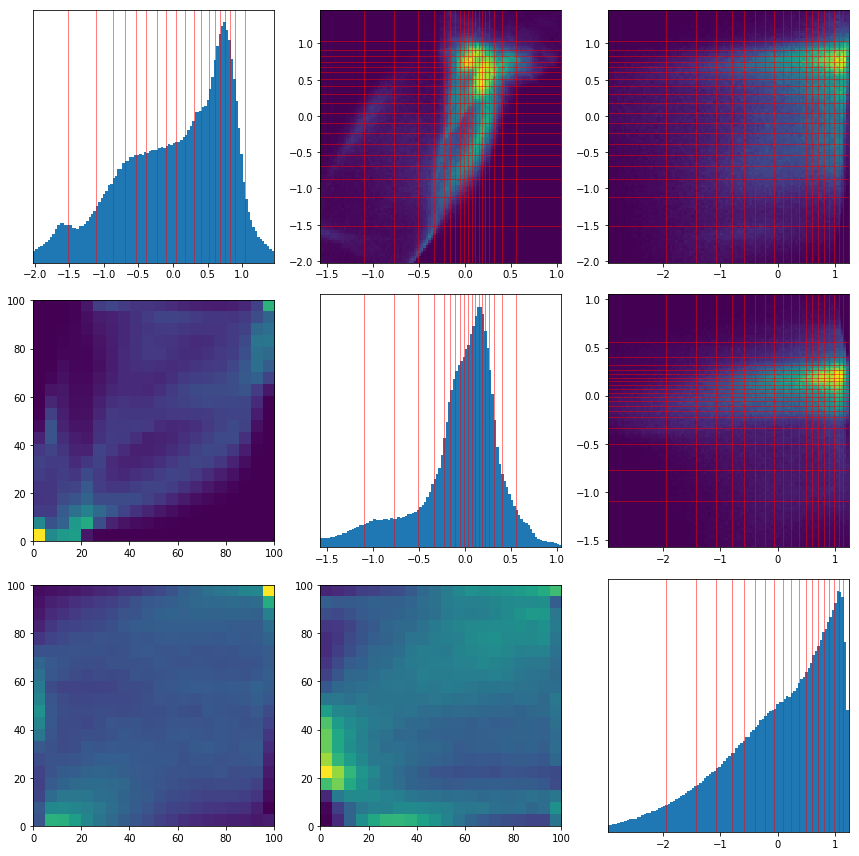

In [37]:
plotfbins(X)

In [12]:
if False:
    n_samples = 10000
    plot_range = [(-2, 2), (-2, 2)]
    n_bins = 100

    scaler = preprocessing.StandardScaler()
    X, _ = datasets.make_moons(n_samples=n_samples, noise=.05)
    X = scaler.fit_transform(X)
    plt.hist2d(X[:, 0], X[:, 1], bins=n_bins, range=plot_range)[-1];

In [38]:
rng, flow_rng = jax.random.split(jax.random.PRNGKey(0))
input_dim = X.shape[1]
num_epochs, batch_size = 200, 2000

In [39]:
def get_masks(input_dim, hidden_dim, num_hidden):
    masks = []
    input_degrees = jnp.arange(input_dim)
    degrees = [input_degrees]

    for n_h in range(num_hidden + 1):
        degrees += [jnp.arange(hidden_dim) % (input_dim - 1)]
    degrees += [input_degrees % input_dim - 1]
    print('degrees:', [d.shape for d in degrees])

    for (d0, d1) in zip(degrees[:-1], degrees[1:]):
        masks += [jnp.transpose(jnp.expand_dims(d1, -1) >= jnp.expand_dims(d0, 0)).astype(jnp.float32)]
    print('masks:', [m.shape for m in masks])
    return masks

hidden_dim = 48 # 64
num_hidden = 2  # 1
nunit = 5       # 5

def masked_transform(rng, input_dim):
    masks = get_masks(input_dim, hidden_dim=hidden_dim, num_hidden=num_hidden)
    act = stax.Relu
    stack = [flows.MaskedDense(masks[0]), act]
    for i in range(num_hidden):
        stack += [flows.MaskedDense(masks[i + 1]), act]
    stack.append(flows.MaskedDense(masks[-1].tile(2)))
    init_fun, apply_fun = stax.serial(*stack)
    _, params = init_fun(rng, (input_dim,))
    return params, apply_fun

# Initialize our flow bijection.
bijection_init_fun = flows.Serial(*(flows.MADE(masked_transform), flows.Reverse()) * nunit)

# Create direct and inverse bijection functions.
bijection_rng, rng = jax.random.split(rng)
bijection_params, bijection_direct, bijection_inverse = bijection_init_fun(bijection_rng, input_dim)

# Initialize our flow model.
prior_init_fun = flows.Normal()
#prior_init_fun = Uniform()
flow_init_fun = flows.Flow(bijection_init_fun, prior_init_fun)
initial_params, log_pdf, sample = flow_init_fun(flow_rng, input_dim)

degrees: [(3,), (48,), (48,), (48,), (3,)]
masks: [(3, 48), (48, 48), (48, 48), (48, 3)]
degrees: [(3,), (48,), (48,), (48,), (3,)]
masks: [(3, 48), (48, 48), (48, 48), (48, 3)]
degrees: [(3,), (48,), (48,), (48,), (3,)]
masks: [(3, 48), (48, 48), (48, 48), (48, 3)]
degrees: [(3,), (48,), (48,), (48,), (3,)]
masks: [(3, 48), (48, 48), (48, 48), (48, 3)]
degrees: [(3,), (48,), (48,), (48,), (3,)]
masks: [(3, 48), (48, 48), (48, 48), (48, 3)]
degrees: [(3,), (48,), (48,), (48,), (3,)]
masks: [(3, 48), (48, 48), (48, 48), (48, 3)]
degrees: [(3,), (48,), (48,), (48,), (3,)]
masks: [(3, 48), (48, 48), (48, 48), (48, 3)]
degrees: [(3,), (48,), (48,), (48,), (3,)]
masks: [(3, 48), (48, 48), (48, 48), (48, 3)]
degrees: [(3,), (48,), (48,), (48,), (3,)]
masks: [(3, 48), (48, 48), (48, 48), (48, 3)]
degrees: [(3,), (48,), (48,), (48,), (3,)]
masks: [(3, 48), (48, 48), (48, 48), (48, 3)]


In [50]:
def loss_fn(params, inputs):
    return -log_pdf(params, inputs).mean()

@jax.jit
def step(i, opt_state, inputs):
    params = get_params(opt_state)
    loss_value, gradients = jax.value_and_grad(loss_fn)(params, inputs)
    return opt_update(i, gradients, opt_state), loss_value

In [51]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-4)

In [52]:
import jax.scipy.special

In [53]:
import scipy.special

epoch 0 loss 3.0052378177642822
epoch 1
float32


/opt/anaconda3/envs/ML/lib/python3.7/site-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


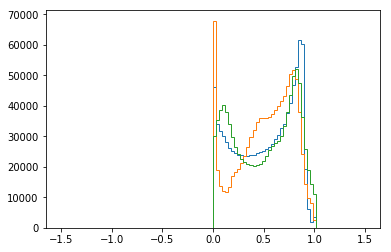

epoch 1 loss 2.6449813842773438
epoch 2 loss 2.505992889404297
epoch 3 loss 2.4537932872772217
epoch 4 loss 2.4845871925354004
epoch 5 loss 2.3528361320495605
epoch 6 loss 2.4618306159973145
epoch 7 loss 2.4320430755615234
epoch 8 loss 2.3877034187316895
epoch 9 loss 2.343158006668091
epoch 10 loss 2.3439502716064453
epoch 11
float32


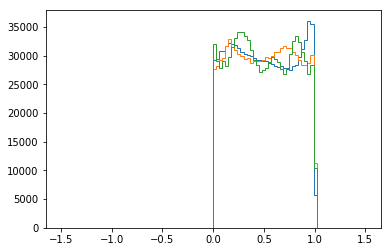

epoch 11 loss 2.3645126819610596
epoch 12 loss 2.426150321960449
epoch 13 loss 2.3732311725616455
epoch 14 loss 2.321376085281372
epoch 15 loss 2.360248565673828
epoch 16 loss 2.3724842071533203
epoch 17 loss 2.3446760177612305
epoch 18 loss 2.3987247943878174
epoch 19 loss 2.3552911281585693
epoch 20 loss 2.3294522762298584
epoch 21
float32


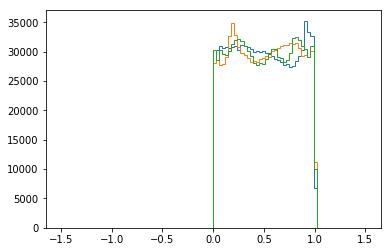

epoch 21 loss 2.3248586654663086
epoch 22 loss 2.3398382663726807
epoch 23 loss 2.348067283630371
epoch 24 loss 2.3775277137756348
epoch 25 loss 2.333034038543701
epoch 26 loss 2.2939772605895996
epoch 27 loss 2.304509401321411
epoch 28 loss 2.392453670501709
epoch 29 loss 2.4264469146728516
epoch 30 loss 2.4045767784118652
epoch 31
float32


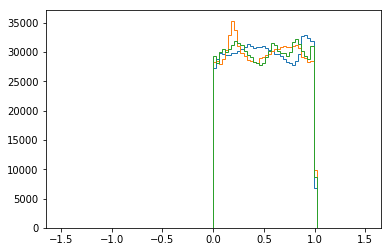

epoch 31 loss 2.345369338989258
epoch 32 loss 2.289940357208252
epoch 33 loss 2.348196506500244
epoch 34 loss 2.2948379516601562
epoch 35 loss 2.3565545082092285
epoch 36 loss 2.348029136657715
epoch 37 loss 2.347412109375
epoch 38 loss 2.3230397701263428
epoch 39 loss 2.317335367202759
epoch 40 loss 2.320216417312622
epoch 41
float32


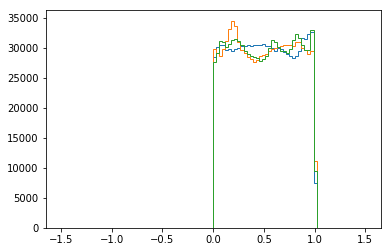

epoch 41 loss 2.312396287918091
epoch 42 loss 2.3150482177734375
epoch 43 loss 2.300260305404663
epoch 44 loss 2.3067855834960938
epoch 45 loss 2.339494228363037
epoch 46 loss 2.2851979732513428
epoch 47 loss 2.3525619506835938
epoch 48 loss 2.326796054840088
epoch 49 loss 2.3042829036712646
epoch 50 loss 2.2919347286224365
epoch 51
float32


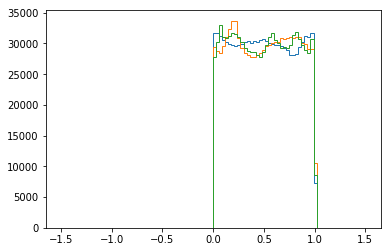

epoch 51 loss 2.381147623062134
epoch 52 loss 2.3454692363739014
epoch 53 loss 2.3322792053222656
epoch 54 loss 2.3132803440093994
epoch 55 loss 2.352367401123047
epoch 56 loss 2.3205132484436035
epoch 57 loss 2.319837808609009
epoch 58 loss 2.320589780807495
epoch 59 loss 2.278914213180542
epoch 60 loss 2.3243398666381836
epoch 61
float32


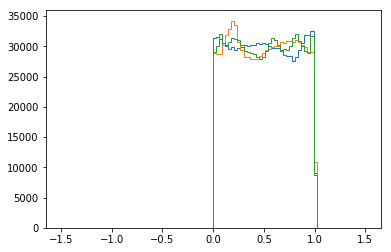

epoch 61 loss 2.3480498790740967
epoch 62 loss 2.307546377182007
epoch 63 loss 2.2938194274902344
epoch 64 loss 2.329453706741333
epoch 65 loss 2.3125436305999756
epoch 66 loss 2.3536629676818848
epoch 67 loss 2.311363458633423
epoch 68 loss 2.3160324096679688
epoch 69 loss 2.304967164993286
epoch 70 loss 2.3638927936553955
epoch 71
float32


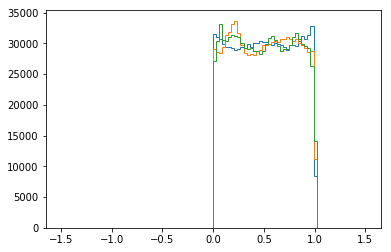

epoch 71 loss 2.2917721271514893
epoch 72 loss 2.369358539581299
epoch 73 loss 2.329489231109619
epoch 74 loss 2.321901321411133
epoch 75 loss 2.3184332847595215
epoch 76 loss 2.322216510772705
epoch 77 loss 2.267454147338867
epoch 78 loss 2.332347869873047
epoch 79 loss 2.2896125316619873
epoch 80 loss 2.275040626525879
epoch 81
float32


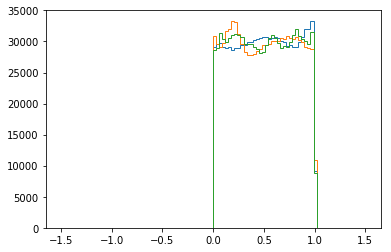

epoch 81 loss 2.3180174827575684
epoch 82 loss 2.299570083618164
epoch 83 loss 2.280733823776245
epoch 84 loss 2.291713237762451
epoch 85 loss 2.316155433654785
epoch 86 loss 2.32593035697937
epoch 87 loss 2.320566177368164
epoch 88 loss 2.3117990493774414
epoch 89 loss 2.3100621700286865
epoch 90 loss 2.3096773624420166
epoch 91
float32


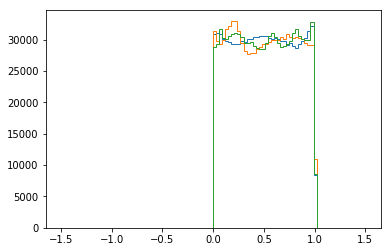

epoch 91 loss 2.3087430000305176
epoch 92 loss 2.325329303741455
epoch 93 loss 2.340758800506592
epoch 94 loss 2.276956081390381
epoch 95 loss 2.2588698863983154
epoch 96 loss 2.3509790897369385
epoch 97 loss 2.321239471435547
epoch 98 loss 2.3206064701080322
epoch 99 loss 2.325267791748047
epoch 100 loss 2.250394105911255
epoch 101
float32


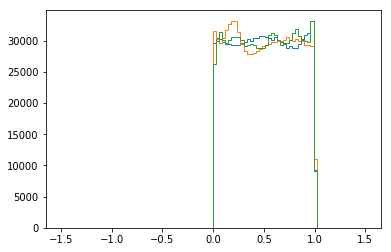

epoch 101 loss 2.322431802749634
epoch 102 loss 2.3158788681030273
epoch 103 loss 2.305006980895996
epoch 104 loss 2.296612024307251
epoch 105 loss 2.245497703552246
epoch 106 loss 2.3112549781799316
epoch 107 loss 2.3011226654052734
epoch 108 loss 2.33320951461792
epoch 109 loss 2.2771317958831787
epoch 110 loss 2.3362038135528564
epoch 111
float32


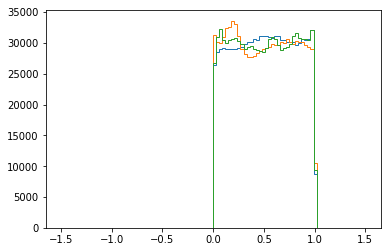

epoch 111 loss 2.275279998779297
epoch 112 loss 2.280795097351074
epoch 113 loss 2.305572748184204
epoch 114 loss 2.2509124279022217
epoch 115 loss 2.2989258766174316
epoch 116 loss 2.2934839725494385
epoch 117 loss 2.301996946334839
epoch 118 loss 2.278733015060425
epoch 119 loss 2.3205955028533936
epoch 120 loss nan
epoch 121
float32
U has 3000000 bad elements.


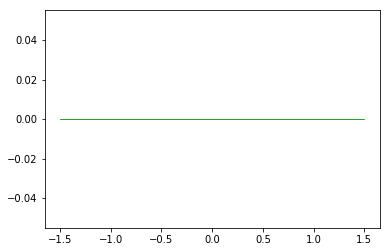

epoch 121 loss nan
epoch 122 loss nan
epoch 123 loss nan
epoch 124 loss nan
epoch 125 loss nan
epoch 126 loss nan
epoch 127 loss nan
epoch 128 loss nan
epoch 129 loss nan
epoch 130 loss nan
epoch 131
float32
U has 3000000 bad elements.


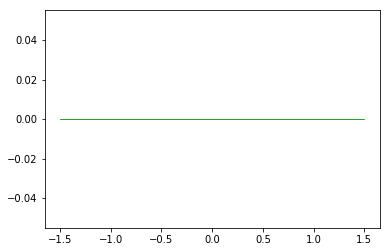

epoch 131 loss nan
epoch 132 loss nan
epoch 133 loss nan
epoch 134 loss nan
epoch 135 loss nan
epoch 136 loss nan
epoch 137 loss nan
epoch 138 loss nan
epoch 139 loss nan
epoch 140 loss nan
epoch 141
float32
U has 3000000 bad elements.


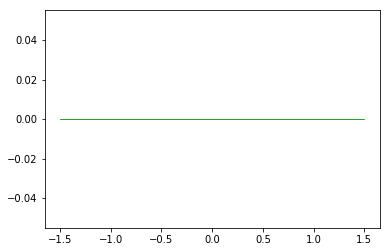

epoch 141 loss nan
epoch 142 loss nan
epoch 143 loss nan
epoch 144 loss nan
epoch 145 loss nan
epoch 146 loss nan
epoch 147 loss nan
epoch 148 loss nan
epoch 149 loss nan
epoch 150 loss nan
epoch 151
float32
U has 3000000 bad elements.


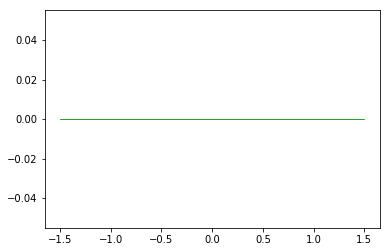

epoch 151 loss nan
epoch 152 loss nan
epoch 153 loss nan
epoch 154 loss nan
epoch 155 loss nan
epoch 156 loss nan
epoch 157 loss nan
epoch 158 loss nan
epoch 159 loss nan
epoch 160 loss nan
epoch 161
float32
U has 3000000 bad elements.


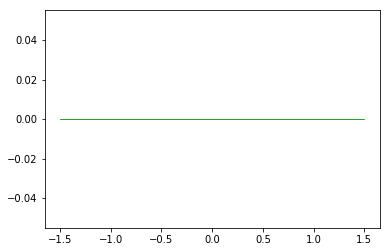

epoch 161 loss nan
epoch 162 loss nan
epoch 163 loss nan
epoch 164 loss nan
epoch 165 loss nan
epoch 166 loss nan
epoch 167 loss nan
epoch 168 loss nan
epoch 169 loss nan
epoch 170 loss nan
epoch 171
float32
U has 3000000 bad elements.


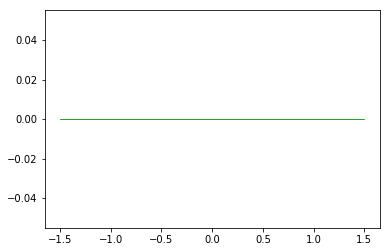

epoch 171 loss nan
epoch 172 loss nan
epoch 173 loss nan
epoch 174 loss nan
epoch 175 loss nan
epoch 176 loss nan
epoch 177 loss nan
epoch 178 loss nan
epoch 179 loss nan
epoch 180 loss nan
epoch 181
float32
U has 3000000 bad elements.


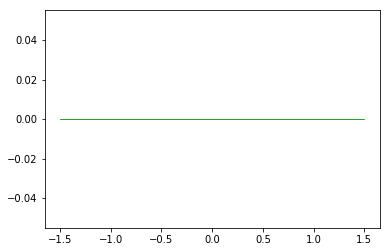

epoch 181 loss nan
epoch 182 loss nan
epoch 183 loss nan
epoch 184 loss nan
epoch 185 loss nan
epoch 186 loss nan
epoch 187 loss nan
epoch 188 loss nan
epoch 189 loss nan
epoch 190 loss nan
epoch 191
float32
U has 3000000 bad elements.


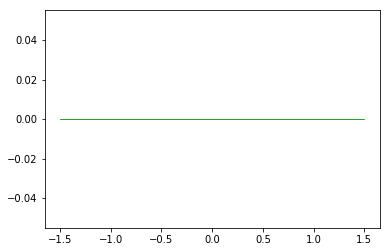

epoch 191 loss nan
epoch 192 loss nan
epoch 193 loss nan
epoch 194 loss nan
epoch 195 loss nan
epoch 196 loss nan
epoch 197 loss nan
epoch 198 loss nan
epoch 199 loss nan
epoch 200
float32
U has 3000000 bad elements.


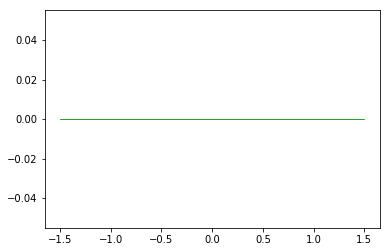

In [54]:
nsample = X.shape[0]
X_trace_in = X.copy()
#bins = np.linspace(-3, 3, 101)
bins = np.linspace(-1.5, 1.5, 101)

opt_state = opt_init(initial_params)
itercount = itertools.count()

for epoch in range(num_epochs):

    permute_rng, rng = jax.random.split(rng)
    X = jax.random.permutation(permute_rng, X)
    for batch_index in range(0, len(X), batch_size):
        opt_state, loss = step(next(itercount), opt_state, X[batch_index:batch_index+batch_size])
        
    print(f'epoch {epoch} loss {loss}')
    
    if epoch % 10 == 0 or epoch == num_epochs - 1:
        print('epoch', epoch + 1)
        epoch_params = get_params(opt_state)
        
        # Map the input data back through the flow to the prior space.
        X_trace_out, log_det_jac_inv = bijection_direct(epoch_params, X_trace_in)
        #U = 0.5 * (1 + jax.scipy.special.erf(X_trace_out / jnp.sqrt(2)))
        U = 0.5 * (1 + scipy.special.erf(X_trace_out.astype(np.float64) / np.sqrt(2)))
        print(U.dtype)
        good = np.isfinite(U)
        if np.any(~good):
            print(f'U has {np.count_nonzero(~good)} bad elements.')
        for i in range(input_dim):
            x = U[:, i]
            plt.hist(x[np.isfinite(x)], bins, histtype='step')
        plt.show()
        '''
        # Draw random samples from the prior and pass them through the flow.
        sample_rng, rng = jax.random.split(rng)
        X_syn = sample(rng, epoch_params, nsample)
        # Plot.
        plt.hist2d(X_syn[:, 0], X_syn[:, 1], bins=n_bins, range=plot_range)
        plt.show()
        '''

In [104]:
import scipy.special

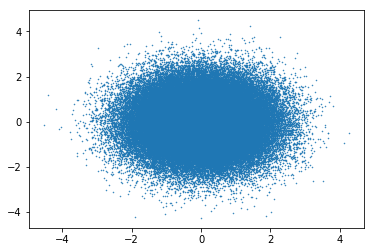

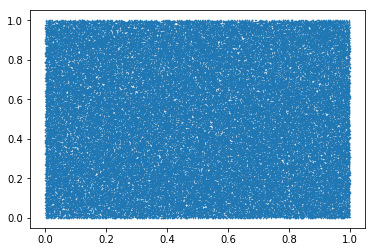

In [118]:
def test_flatten(n=100000, dim=3):
    x = np.random.normal(size=(n, dim))
    plt.plot(x[:, 0], x[:, 1], '.', ms=1)
    plt.show()
    
    y = 0.5 * (1 + scipy.special.erf(x/np.sqrt(2)))
    plt.plot(y[:, 0], y[:, 1], '.', ms=1)
    plt.show()
    
test_flatten()